In [26]:
import os
import numpy as np
import pandas as pd
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.models.damp import DAMP
from TSB_UAD.vus.metrics import get_metrics
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.sand import SAND
from sklearn.preprocessing import MinMaxScaler
import math 


# Read data -- create/read a normality-2 dataset named `combined.csv`
# filepath = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts1 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts2 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_20.out"
# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

filepath = 'MBA_ECG14046_data_9_20.csv'
name = filepath.split('/')[-1]
if not os.path.exists(filepath):
    df1 = pd.read_csv(ts1, header=None).dropna().to_numpy()
    df2 = pd.read_csv(ts2, header=None).dropna().to_numpy()
    combined = np.vstack((df1, df2))
    pd.DataFrame(combined).to_csv(filepath, header=False, index=False)

df = pd.read_csv(filepath, header=None).dropna().to_numpy()
data = df[:, 0].astype(float)
labels = df[:, 1].astype(int)


In [6]:
# Preprocessing
# slidingWindow = 10 # user defined

# or auto sliding window length
slidingWindow = find_length(data)
X_data = Window(window=slidingWindow).convert(data).to_numpy()

In [61]:
def evaluate(score, modelName, slidingWindow, name, predict=True):
    from TSB_UAD.vus import metrics
    from importlib import reload
    metrics = reload(metrics)
    # post processing
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    if predict:
        score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
    for metric in results.keys():
        print(metric, ":", results[metric])
    plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

AUC_ROC : 0.5377203165344974
AUC_PR : 0.10673764900112394
Precision : 0.30143784196462653
Recall : 0.10394910048266784
F : 0.15458905673920845
Precision_at_k : 0.10394910048266784
Rprecision : 0.26907917741642984
Rrecall : 0.09938210526322833
RF : 0.1451531348947283
R_AUC_ROC : 0.8206725071024382
R_AUC_PR : 0.2779464623639834
VUS_ROC : 0.7215768283114047
VUS_PR : 0.19099228230070384
Affiliation_Precision : 0.8122977849158274
Affiliation_Recall : 0.09200945640959314


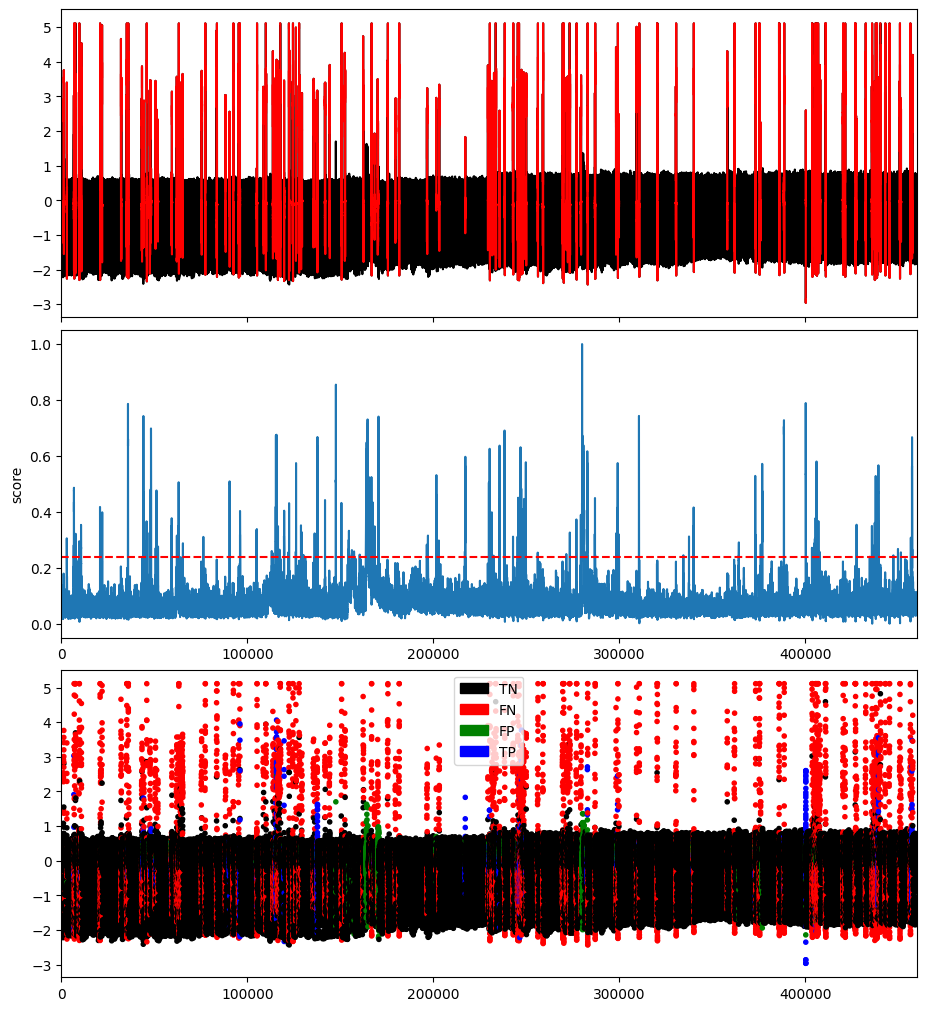

In [ ]:
# Run MatrixProfile
modelName = 'MatrixProfile'
clf = MatrixProfile(window=slidingWindow) # takes 1.5 minutes
clf.fit(data)
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

AUC_ROC : 0.9450712729053256
AUC_PR : 0.6622921734932949
Precision : 0.7016784683975872
Recall : 0.46959192628345764
F : 0.5626412912044582
Precision_at_k : 0.46959192628345764
Rprecision : 0.5289925826524243
Rrecall : 0.38044350160139556
RF : 0.44258589240073615
R_AUC_ROC : 0.993741611421336
R_AUC_PR : 0.92925813361278
VUS_ROC : 0.9886584980120651
VUS_PR : 0.8556782179685721
Affiliation_Precision : 0.95789127594948
Affiliation_Recall : 0.7664418843997189


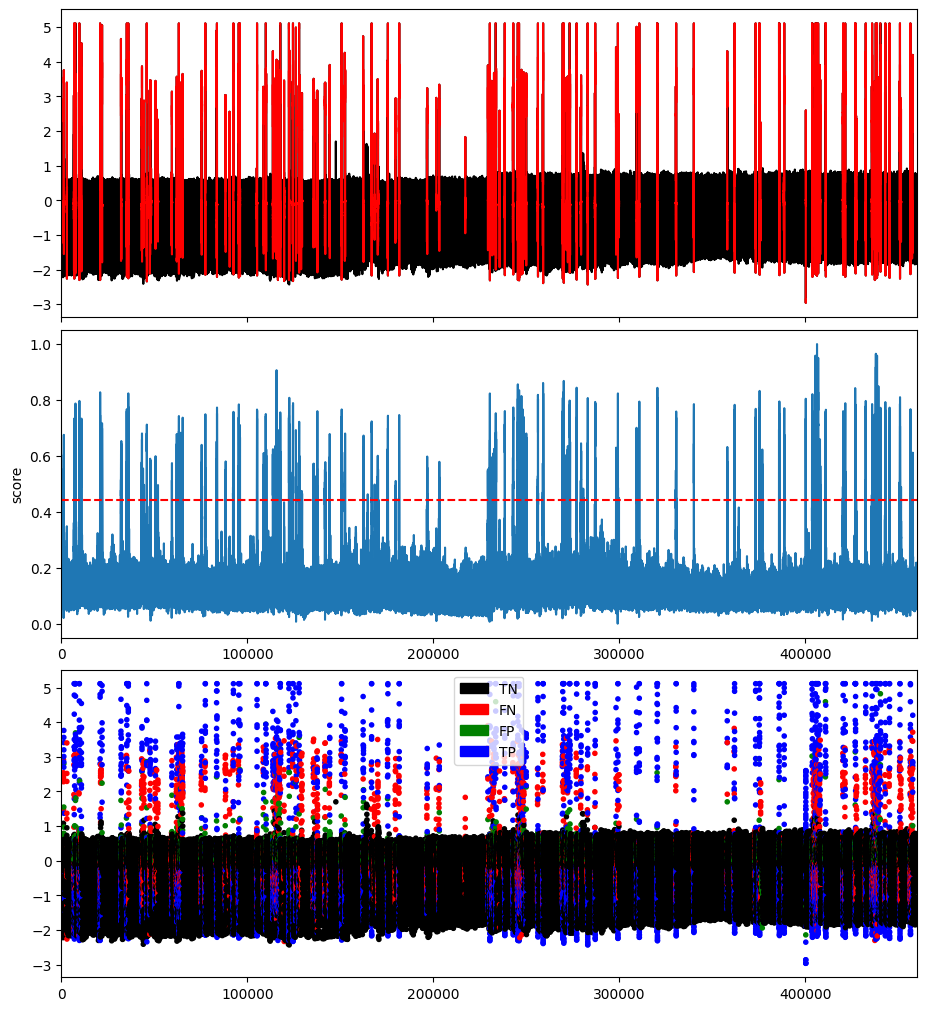

In [ ]:
# Run Isolation Forest
modelName = 'IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

In [23]:
# SAND online
# ---- WARNING: this takese 40 mins to complete!!
modelName = 'SAND (online)'
clf = SAND(pattern_length=slidingWindow, subsequence_length=4*slidingWindow)
# length = len(data)//100 # not sure ?
clf.fit(data, overlaping_rate=int(4*slidingWindow), online=True, alpha=.5, init_length=5000, batch_size=2000,verbose=True,) # 100 batches 
score = clf.decision_scores_
evaluate(score, modelName, name=name, slidingWindow=slidingWindow, predict=False)

0-->5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->51000-->53000-->55000-->57000-->59000-->61000-->63000-->65000-->67000-->69000-->71000-->73000-->75000-->77000-->79000-->81000-->83000-->85000-->87000-->89000-->91000-->93000-->95000-->97000-->99000-->101000-->103000-->105000-->107000-->109000-->111000-->113000-->115000-->117000-->119000-->121000-->123000-->125000-->127000-->129000-->131000-->133000-->135000-->137000-->139000-->141000-->143000-->145000-->147000-->149000-->151000-->153000-->155000-->157000-->159000-->161000-->163000-->165000-->167000-->169000-->171000-->173000-->175000-->177000-->179000-->181000-->183000-->185000-->187000-->189000-->191000-->193000-->195000-->197000-->199000-->201000-->203000-->205000-->207000-->209000-->211000-->213000-->215000-->217000-->219000-->221000-->223000-->225000-->227000-->229000-->231000-->233000-->235000-->237

TypeError: evaluate() takes 2 positional arguments but 4 were given

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
AUC_ROC : 0.9694712894463864
AUC_PR : 0.6034909294549364
Precision : 0.6811039323602137
Recall : 0.37468187801667396
F : 0.4834262745209047
Precision_at_k : 0.37468187801667396
Rprecision : 0.6923529249134656
Rrecall : 0.43637284671699195
RF : 0.5353364375492252
R_AUC_ROC : 0.9896885487280913
R_AUC_PR : 0.8668327187977996
VUS_ROC : 0.9837526922587895
VUS_PR : 0.7647296187898841
Affiliation_Precision : 0.9576581214600048
Affiliation_Recall : 0.633423202985811
max_length=459800


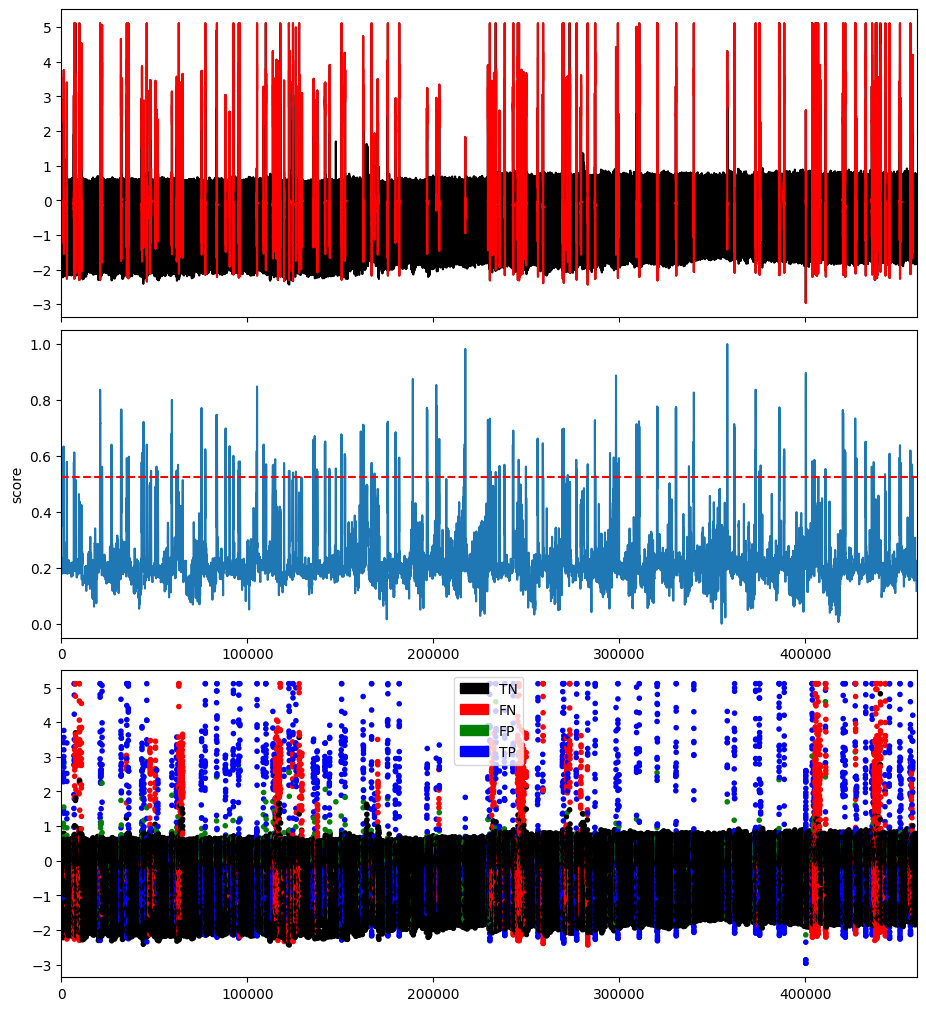

In [62]:
%load_ext autoreload
evaluate(score, modelName, name=name, slidingWindow=slidingWindow, predict=False)